In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from TransformerCVAE import TransformerCVAE, train_epoch, validate, generate_samples

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


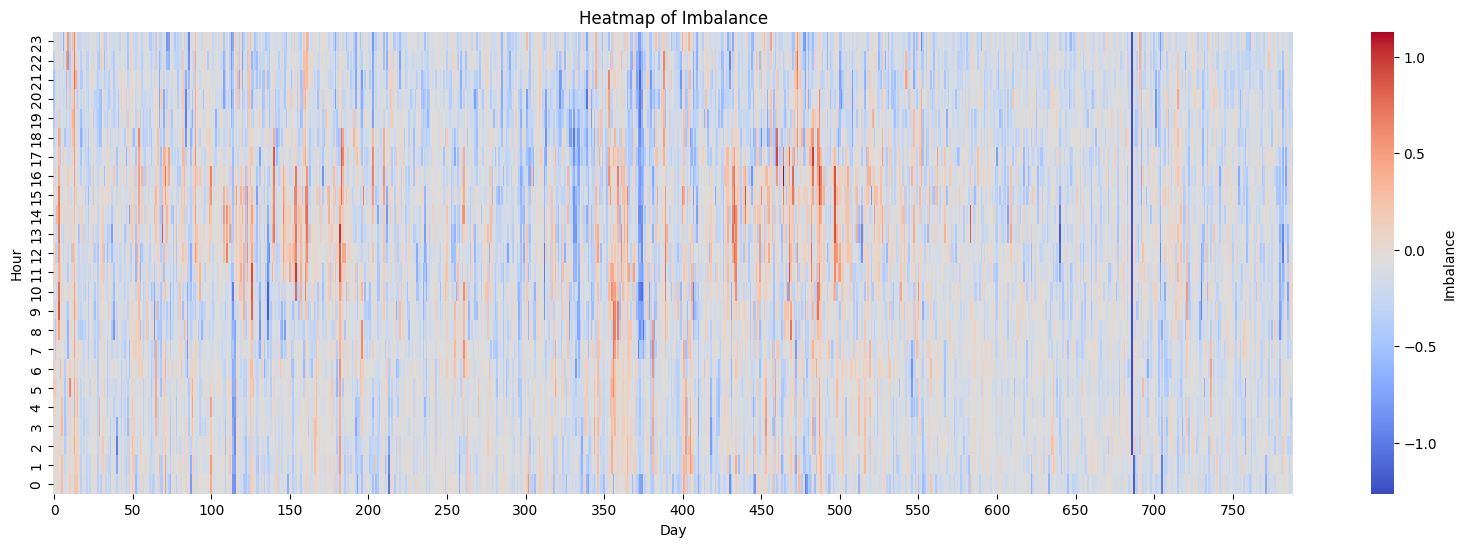

In [4]:
# Load and prepare data
X = np.load("../data/X.npy")
condition = X[:, :3, :]
target = X[:, 3, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32).permute(0, 2, 1) # Shape: (N_days, 24, 3)
target_tensor = torch.tensor(target, dtype=torch.float32).unsqueeze(-1)    # Shape: (N_days, 24, 1)


dataset = TensorDataset(cond_tensor, target_tensor)

# Model parameters FOR INSTANTIATION
cond_dim = 3      # Number of condition features per time step
target_dim = 1    # Number of target features per time step
latent_dim = 16
seq_len = 24      # Explicit sequence length
# Define d_model, nhead, num_layers as needed for your model
# Example: d_model=256, nhead=8, num_layers=3

# Split data
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2**8, shuffle=False)

# Visualize target data
plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()

In [9]:
# Create mask for evaluation
mask = torch.zeros(24)
mask[12:] = 1
print("Mask:", mask)

Mask: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])


In [10]:
def pinball_loss(y_true, y_pred, quantile, masked=False, mask=None):
    error = y_true - y_pred
    loss_tensor = torch.where(error >= 0, quantile * error, (quantile - 1) * error)
    if masked:
        if mask is None:
            raise ValueError("Masked loss requested but no mask provided.")
        mask = mask.to(y_true.device).float()
        mask = mask.unsqueeze(0).expand_as(y_true)
        loss = (loss_tensor * mask).sum() / mask.sum()
    else:
        loss = torch.mean(loss_tensor)
    return loss

In [11]:
def crps_loss(y_true, samples):
    num_samples = samples.shape[0]
    y_true_expanded = y_true.unsqueeze(0).expand(num_samples, *y_true.shape)

    # First term: average absolute difference between each sample and the true value
    term1 = torch.abs(samples - y_true_expanded).mean(dim=0)

    # Second term: average pairwise absolute differences among samples
    diff = torch.abs(samples.unsqueeze(0) - samples.unsqueeze(1))
    term2 = diff.mean(dim=(0, 1))
    
    # CRPS per instance and target dimension
    crps = term1 - 0.5 * term2
    return crps.mean()

In [5]:
# Initialize model
model = TransformerCVAE(
    cond_dim=cond_dim,
    target_dim=target_dim,
    latent_dim=latent_dim,
    nhead=8,
    num_layers=3
    ).to(device)
    
# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# Training loop
num_epochs = 2**12
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}\n")

KeyboardInterrupt: 

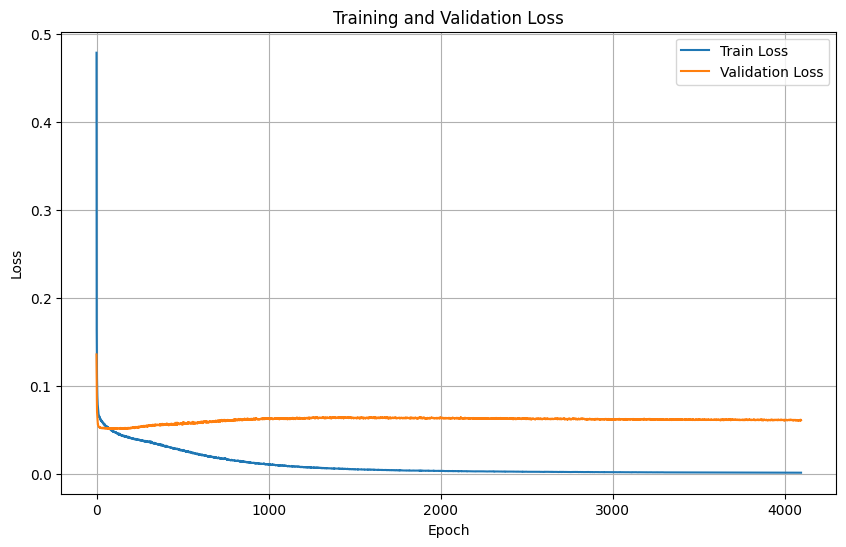

In [14]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Evaluate Pinball Loss
quantile = 0.9
val_pinball_loss = 0.0
model.eval()
with torch.no_grad():
    for batch_cond, batch_target in val_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss_pinball = pinball_loss(batch_target, recon_target, quantile)
        val_pinball_loss += loss_pinball.item() * batch_cond.size(0)
val_pinball_loss /= len(val_dataset)
print(f"Validation Pinball Loss (quantile={quantile}): {val_pinball_loss:.4f}")

Validation Pinball Loss (quantile=0.9): 0.0868


In [16]:
# Generate and visualize samples
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)

    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)

    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])


Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([-0.1560, -0.1920, -0.1560, -0.0500, -0.0450, -0.2100, -0.1330, -0.4460,
        -0.3080, -0.4810, -0.4360, -0.4090, -0.2440, -0.2070, -0.0120, -0.0530,
        -0.1450, -0.5020, -0.0510, -0.1700, -0.2090, -0.0990, -0.2470, -0.1830])
Sample 1 Predicted Imbalance:
tensor([-0.1707, -0.2944, -0.2201, -0.1561, -0.1775, -0.1189, -0.0134, -0.1012,
        -0.1746, -0.2960, -0.2682, -0.0974, -0.0672, -0.0584, -0.0094,  0.0365,
        -0.1075, -0.1714, -0.2370, -0.1719, -0.1294, -0.1522, -0.1086, -0.0875])

Sample 2 True Imbalance:
tensor([-0.1370, -0.1220, -0.0890, -0.0050, -0.1380, -0.2670, -0.1650, -0.1950,
        -0.4040, -0.3340, -0.2920, -0.0640, -0.0240, -0.5960, -0.7550, -0.5170,
        -0.3740, -0.1660, -0.3060, -0.4010, -0.4190, -0.2190, -0.0230, -0.0580])
Sample 2 Predicted Imbalance:
tensor([-0.0239, -0.0176, -0.0627, -0.2024, -0.1313, -0.1304, -0.1805, -0.1715,
        -0.1366, -0.1298, -0.2154, -0.

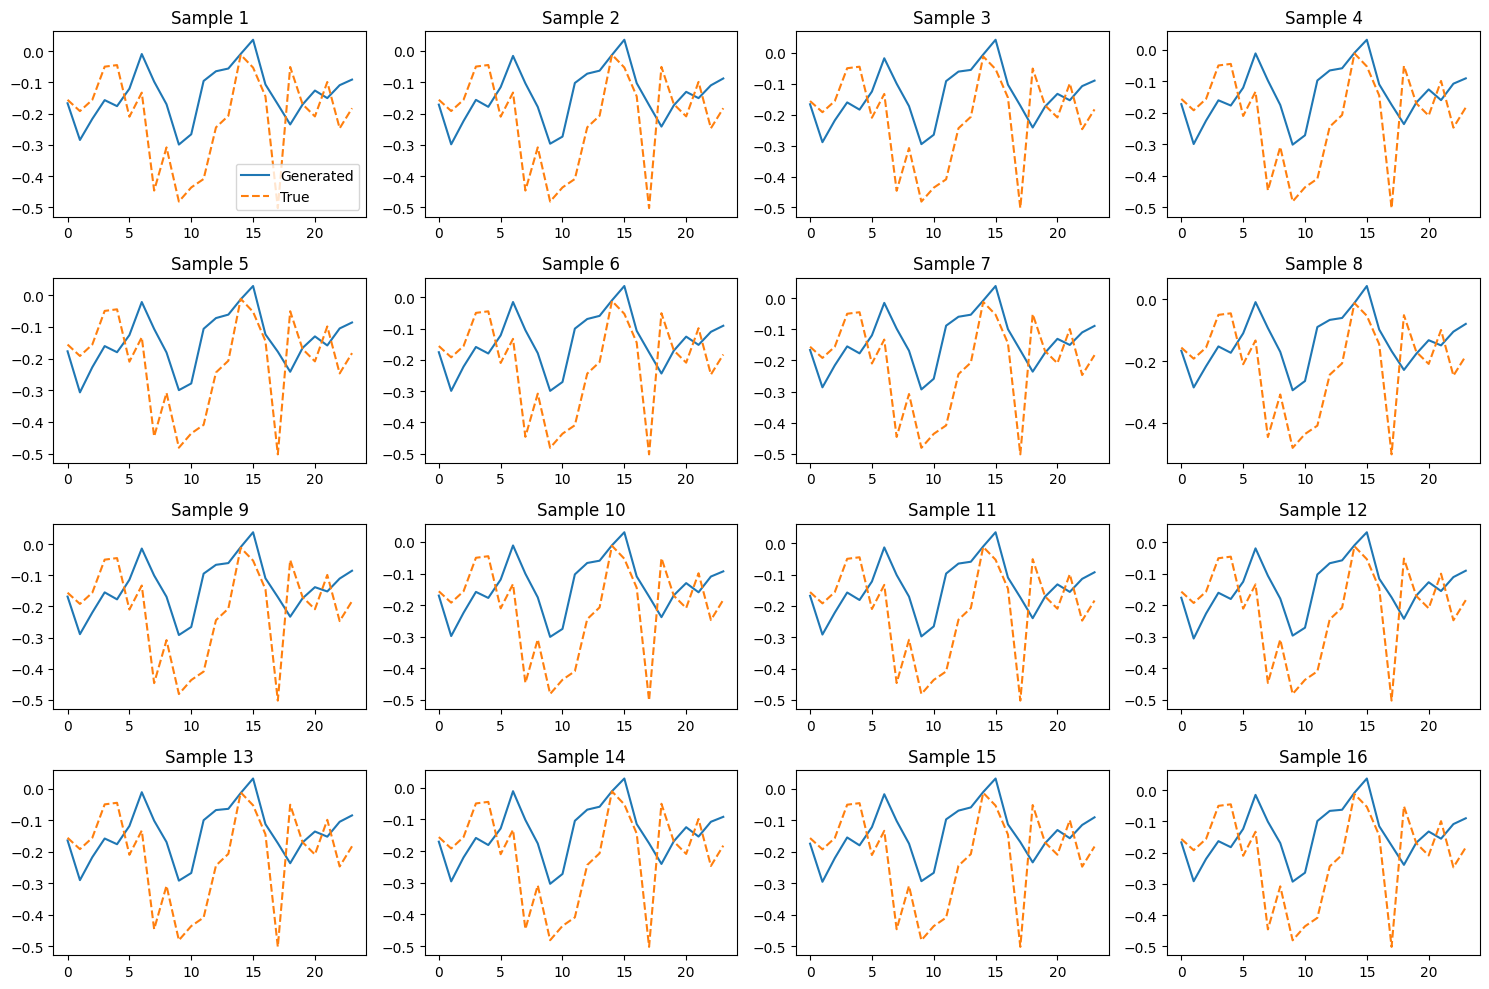

In [18]:
# Generate multiple samples for visualization
num_samples = 16
samples = []
sample_cond, sample_target = next(iter(val_loader))
sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
sample_target = sample_target.to(device)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        mu, logvar = model.encoder(sample_cond_flat, sample_target)
        z = model.reparameterize(mu, logvar)
        recon_target = model.decoder(sample_cond_flat, z)
        samples.append(recon_target.cpu().numpy())

# Plot samples
samples = np.array(samples)
plt.figure(figsize=(15, 10))
for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i+1)
    plt.plot(samples[i, 0], label='Generated')
    plt.plot(sample_target[0].cpu().numpy(), '--', label='True' if i == 0 else '')
    if i == 0:
        plt.legend()
    plt.title(f'Sample {i+1}')
plt.tight_layout()
plt.show()